In [0]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict

In [2]:
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
_graph_replace = tf.contrib.graph_editor.graph_replace

def remove_original_op_attributes(graph):
    """Remove _original_op attribute from all operations in a graph."""
    for op in graph.get_operations():
        op._original_op = None
        
def graph_replace(*args, **kwargs):
    """Monkey patch graph_replace so that it works with TF 1.0"""
    remove_original_op_attributes(tf.get_default_graph())
    return _graph_replace(*args, **kwargs)

W0618 12:07:45.909957 140486783227776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
def extract_update_dict(update_ops):
    """Extract variables and their new values from Assign and AssignAdd ops.
    
    Args:
        update_ops: list of Assign and AssignAdd ops, typically computed using Keras' opt.get_updates()

    Returns:
        dict mapping from variable values to their updated value
    """
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        else:
            raise ValueError("Update op type (%s) must be of type Assign or AssignAdd"%update_op.op.type)
    return updates

In [0]:
def sample_mog(batch_size, n_mixture=8, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

In [0]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=2, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

In [0]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=25000,
    viz_every=5000,
    z_dim=256,
    x_dim=2,
    unrolling_steps=5,
)

In [0]:
ds = tf.contrib.distributions
slim = tf.contrib.slim

In [9]:
tf.__version__

'1.14.0-rc1'

In [10]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])

noise = ds.Normal(tf.zeros(params['z_dim']), 
                  tf.ones(params['z_dim'])).sample(params['batch_size'])
# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))
print(loss.shape)
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
d_opt = Adam(lr=params['disc_learning_rate'], beta_1=params['beta1'], epsilon=params['epsilon'])
print(disc_vars)
updates = d_opt.get_updates(disc_vars, [], loss)
print(updates)
d_train_op = tf.group(*updates, name="d_train_op")
print(d_train_op)

# Unroll optimization of the discrimiantor
if params['unrolling_steps'] > 0:
    # Get dictionary mapping from variables to their update value after one optimization step
    update_dict = extract_update_dict(updates)
    print(update_dict)
    cur_update_dict = update_dict
    for i in range(params['unrolling_steps'] - 1):
        # Compute variable updates given the previous iteration's updated variable
        cur_update_dict = graph_replace(update_dict, cur_update_dict)
    # Final unrolled loss uses the parameters at the last time step
    unrolled_loss = graph_replace(loss, cur_update_dict)
else:
    unrolled_loss = loss

# Optimize the generator on the unrolled loss
g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_op = g_train_opt.minimize(-unrolled_loss, var_list=gen_vars)

W0618 12:07:46.052419 140486783227776 deprecation.py:323] From <ipython-input-5-ab91f8bdd5ef>:4: Categorical.__init__ (from tensorflow.python.ops.distributions.categorical) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0618 12:07:46.059405 140486783227776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/distributions/categorical.py:242: Distribution.__init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0618 12:07:46.

()
[<tf.Variable 'discriminator/Stack/fully_connected_1/weights:0' shape=(2, 128) dtype=float32_ref>, <tf.Variable 'discriminator/Stack/fully_connected_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/Stack/fully_connected_2/weights:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'discriminator/Stack/fully_connected_2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/fully_connected/weights:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'discriminator/fully_connected/biases:0' shape=(1,) dtype=float32_ref>]


W0618 12:07:47.817948 140486783227776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/decorator_utils.py:145: GraphKeys.VARIABLES (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


[<tf.Tensor 'AssignAdd:0' shape=() dtype=int64_ref>, <tf.Tensor 'Assign:0' shape=(2, 128) dtype=float32_ref>, <tf.Tensor 'Assign_1:0' shape=(2, 128) dtype=float32_ref>, <tf.Tensor 'Assign_2:0' shape=(2, 128) dtype=float32_ref>, <tf.Tensor 'Assign_3:0' shape=(128,) dtype=float32_ref>, <tf.Tensor 'Assign_4:0' shape=(128,) dtype=float32_ref>, <tf.Tensor 'Assign_5:0' shape=(128,) dtype=float32_ref>, <tf.Tensor 'Assign_6:0' shape=(128, 128) dtype=float32_ref>, <tf.Tensor 'Assign_7:0' shape=(128, 128) dtype=float32_ref>, <tf.Tensor 'Assign_8:0' shape=(128, 128) dtype=float32_ref>, <tf.Tensor 'Assign_9:0' shape=(128,) dtype=float32_ref>, <tf.Tensor 'Assign_10:0' shape=(128,) dtype=float32_ref>, <tf.Tensor 'Assign_11:0' shape=(128,) dtype=float32_ref>, <tf.Tensor 'Assign_12:0' shape=(128, 1) dtype=float32_ref>, <tf.Tensor 'Assign_13:0' shape=(128, 1) dtype=float32_ref>, <tf.Tensor 'Assign_14:0' shape=(128, 1) dtype=float32_ref>, <tf.Tensor 'Assign_15:0' shape=(1,) dtype=float32_ref>, <tf.Tenso

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

  0%|          | 0/25000 [00:00<?, ?it/s]

Populating the interactive namespace from numpy and matplotlib


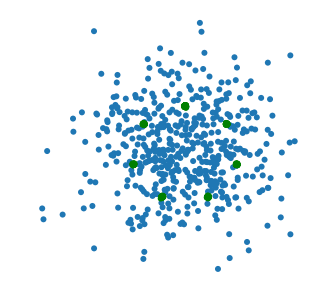

 20%|█▉        | 4999/25000 [05:25<21:11, 15.73it/s]

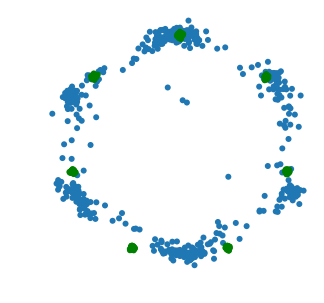

 20%|██        | 5125/25000 [05:33<21:27, 15.44it/s]

In [0]:
%pylab inline
from tqdm import tqdm
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
for i in tqdm(range(params['max_iter'])):
    f, _, _ = sess.run([[loss, unrolled_loss], g_train_op, d_train_op])
    fs.append(f)
    if i % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none')
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')
        axis('off')
        if generate_movie:
            frames.append(mplfig_to_npimage(fig))
        show()